## PPI

Questions:
1. How to represent psychological regressor on the neural level? Normally, task onsets are convolved with continuous HRF and then downsampled to match volume acquisition ($f = \frac{1}{TR}$) creating regressor in the BOLD signal space.
2. Is it necessary to include outcome phase onset regressor (representing "baseline" or constant in the event related setup) as a confound regressor?
3. Should confounds like motion parameters be regressed during timeseries extraction step?

![Connectivity workflow](connectivity_workflow.png)

In [9]:
import os
from bids import BIDSLayout

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data                    

In [7]:
# Directory to save first-level output
path_out = os.path.join(path_root, 
                        'data/main_fmri_study/derivatives/ppi')
os.makedirs(path_out, exist_ok=True)

# Load behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh)
n_subjects, n_conditions, n_trials, _ = beh.shape

Shape of beh array: (32, 2, 110, 23)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'block_bci'), (2, 'side'), (3, 'side_bci'), (4, 'magn_left'), (5, 'magn_right'), (6, 'response'), (7, 'rt'), (8, 'won_bool'), (9, 'won_magn'), (10, 'acc_after_trial'), (11, 'onset_iti'), (12, 'onset_iti_plan'), (13, 'onset_iti_glob'), (14, 'onset_dec'), (15, 'onset_dec_plan'), (16, 'onset_dec_glob'), (17, 'onset_isi'), (18, 'onset_isi_plan'), (19, 'onset_isi_glob'), (20, 'onset_out'), (21, 'onset_out_plan'), (22, 'onset_out_glob')]


### Query neuroimaging dataset

Using BIDSLayout object query BIDS dataset to pull out necessary files.
- `anat_files`: sorted list of preprocessed T1w images
- `fmri_files`: list of two lists containing sorted (by subject number) paths to imaging files, first list corresponds to reward condition of PRL task and second list corresponds to punishment condition of PRL task
- `conf_files`: list of two lists containing sorted (by subject number) paths to confound files
- `mask_files`: brain mask files for fmri sequencnes

In [10]:
path_bids = os.path.join(path_root, 'data/main_fmri_study')

layout = BIDSLayout(
    root=path_bids,
    derivatives=True,
    validate=True,
    index_metadata=False
)

anat_filter = {
    "extension": [".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "suffix": "T1w",
    "desc": "preproc",
    "return_type": "filename"
}

fmri_filter = {
    "extension": [".nii", ".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "suffix": "bold",
    "desc": "preproc",
    "return_type": "filename"
}

conf_filter = {
    "extension": "tsv",
    "desc": "confounds",
    "return_type": "filename"
}

mask_filter = {
    "extension": [".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "desc": "brain",
    "suffix": "mask",
    "return_type": "filename"
}

anat_files = layout.get(**anat_filter)

fmri_files, conf_files, mask_files = [], [], []

for task_dict in [{"task": "prlrew"}, {"task": "prlpun"}]:
    fmri_filter.update(task_dict)
    conf_filter.update(task_dict)
    mask_filter.update(task_dict)
    fmri_files.append(layout.get(**fmri_filter))
    conf_files.append(layout.get(**conf_filter))
    mask_files.append(layout.get(**mask_filter))

In [29]:
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
import matplotlib.pyplot as plt

In [24]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
labels = dataset.labels

print('Atlas ROIs are located in nifti image (4D) at: %s' %
      atlas_filename)  # 4D data

atlas_filename = dataset.maps
fmri_filename = fmri_files[0][0]

Atlas ROIs are located in nifti image (4D) at: /home/kmb/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz


In [25]:
masker = NiftiLabelsMasker(
    labels_img=atlas_filename, 
    standardize=True,
    memory='nilearn_cache', 
    verbose=5)

time_series = masker.fit_transform(fmri_filename)

[NiftiLabelsMasker.fit_transform] loading data from /home/kmb/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/main_fmri_study/derivatives/fmriprep/sub-m02/func/sub-m02_task-prlrew_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'labels_img': '/home/kmb/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5

In [28]:
time_series.shape

(730, 48)

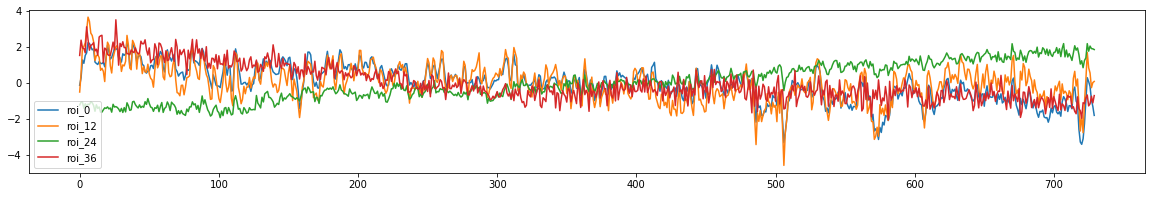

In [33]:
fig, ax = plt.subplots(figsize=(20, 3), facecolor='w')

for roi in range(0, 48, 12):
    ax.plot(time_series[:, roi], label=f'roi_{roi}')
    
ax.legend()